In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import xml.dom.minidom as minidom
import glob
import torch
import cv2
import os
import  xml.dom.minidom
from torch.utils.data import Dataset, DataLoader 

In [2]:
%pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.2.93 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


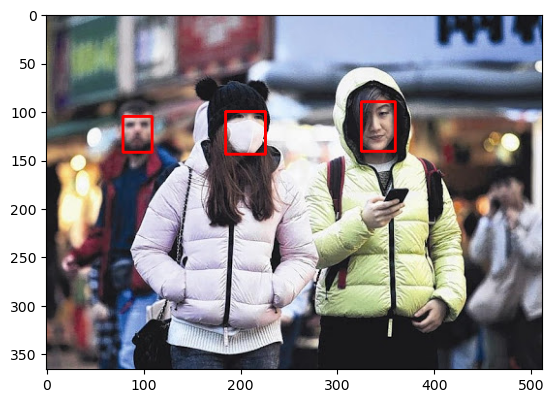


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

In [3]:
images_path = "/kaggle/input/face-mask-detection/images/*"
annot_path = "/kaggle/input/face-mask-detection/annotations/*"

images = ski.io.imread_collection(images_path).files 
annotations = sorted(glob.glob(annot_path))


# Show sample image and print bounding boxes from the corresponding label

test_img = ski.io.imread(images[0])

dom = xml.dom.minidom.parse(annotations[0])
root = dom.documentElement
objects = dom.getElementsByTagName("object")

for i, object in enumerate(objects):
    bndbox = root.getElementsByTagName('bndbox')[i]
    xmin = bndbox.getElementsByTagName('xmin')[0]
    ymin = bndbox.getElementsByTagName('ymin')[0]
    xmax = bndbox.getElementsByTagName('xmax')[0]
    ymax = bndbox.getElementsByTagName('ymax')[0]
    xmin_data=xmin.childNodes[0].data
    ymin_data=ymin.childNodes[0].data
    xmax_data=xmax.childNodes[0].data
    ymax_data=ymax.childNodes[0].data
    cv2.rectangle(test_img, (int(xmin_data), int(ymin_data)), (int(xmax_data), int(ymax_data)), (255, 0, 0), 2)

plt.imshow(test_img), plt.show()


# Also show xml format of the label

with open(annotations[0]) as test_label:
    text = test_label.read()
    print(text)

In [4]:
# Create train, val and test paths
os.mkdir('/kaggle/working/train')
os.mkdir('/kaggle/working/val')
os.mkdir('/kaggle/working/test')

os.mkdir('/kaggle/working/train/img')
os.mkdir('/kaggle/working/train/labels')
os.mkdir('/kaggle/working/val/img')
os.mkdir('/kaggle/working/val/labels')
os.mkdir('/kaggle/working/test/img')
os.mkdir('/kaggle/working/test/pred')

### The annotation format is currently in Pascal Voc xml, which is currently not suitable for YOLO. We have to convert the bounding boxes for txt format:

In [5]:
def xml_to_yolo_bbox(bbox, w, h):
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2 ) / h
    
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    
    return [x_center, y_center, width, height]


def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center, width, height
    w_half_len = (bbox[2] + w) / 2
    h_half_len = (bbox[3] + h) / 2
    
    xmin = int((bbox[0] + w) - w_half_len)
    ymin = int((bbox[1] + h) - h_half_len)
    xmax = int((bbox[0] + w) + w_half_len)
    ymax = int((bbox[1] + h) + h_half_len)
    
    return [xmin, ymin, xmax, ymax]

classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

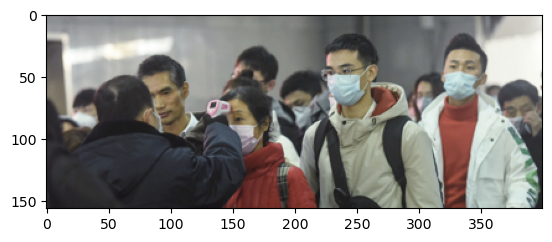


<annotation>
    <folder>images</folder>
    <filename>maksssksksss1.png</filename>
    <size>
        <width>400</width>
        <height>156</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>321</xmin>
            <ymin>34</ymin>
            <xmax>354</xmax>
            <ymax>69</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>224</xmin>
            <ymin>38</ymin>
            <xmax>261</xmax>
            <ymax>73</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated

In [6]:
class mask_dataset(Dataset):
    
    def __init__(self, img_path, annot_path):

        self.images = [ski.io.imread(img) for img in ski.io.imread_collection(img_path).files]
        self.labels = [
            open(label).read()
            for label in sorted(glob.glob(annot_path))
        ]
        
    def __getitem__(self, idx):
        
        image = self.images[idx]
        label = self.labels[idx]
        
        return image, label
    

dataset = mask_dataset(images_path, annot_path)

test_data = dataset[1]
plt.imshow(test_data[0]), plt.show()
print(test_data[1])

# Build and train model

In [7]:
model = YOLO("yolov8n.pt")  # pre-trained weights

#model.train(data = , epochs = 10)

100%|██████████| 6.25M/6.25M [00:00<00:00, 109MB/s]
